In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.manifold import TSNE
import sklearn.preprocessing as sp

import torch
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


H, W = 256, 256

def equalizeHist(img):
    if len(img.shape)==3:
        for j in range(3):
            img[:, :, j] = cv2.equalizeHist(img[:, :, j])
    elif len(img.shape)==2:
        img = cv2.equalizeHist(img)
    return img

def clipping(img_, clip_max=255):
    img = img_ * 255
    return img.clip(0, clip_max).astype('uint8')

def resize(img, h, w):
    return cv2.resize(img, (h, w), interpolation=cv2.INTER_NEAREST)


path='../samples/image'
vv = cv2.imread(os.path.join(path, '0_VV.tif'), -1)
vh = cv2.imread(os.path.join(path, '0_VH.tif'), -1)
vv1 = cv2.imread(os.path.join(path, '1_VV.tif'), -1)
vh1 = cv2.imread(os.path.join(path, '1_VH.tif'), -1)
test = cv2.imread(os.path.join(path, 'test.png'), 0)
vv, vh, vv1, vh1, test = clipping(vv), clipping(vh), clipping(vv1), clipping(vh1), clipping(test)
vv, vh, vv1, vh1, test = equalizeHist(vv), equalizeHist(vh), equalizeHist(vv1), equalizeHist(vh1), equalizeHist(test)
vv, vh, vv1, vh1, test = resize(vv, H, W), resize(vh, H, W), resize(vv1, H, W), resize(vh1, H, W), resize(test, H, W)
vv, vh, vv1, vh1, test = vv/255, vh/255, vv1/255, vh1/255, test/255
sub = (vv1 - vv)+(vh1 - vh)

vv, vh, vv1, vh1, sub, test = np.ravel(vv), np.ravel(vh), np.ravel(vv1), np.ravel(vh1), np.ravel(sub), np.ravel(test)

In [2]:
arr = np.vstack([vv, vh, vv1, vh1, sub, test])
df = pd.DataFrame(data=arr.T)#.plot()#.get_figure().savefig('df1.png')
df.columns=['vv', 'vh', 'vv1', 'vh1', 'sub', 'test']
print(df.shape)
df.head()

(65536, 6)


,vv,vh,vv1,vh1,sub,test
0,0.066667,0.050980,0.086275,0.054902,0.023529,0.0
1,0.341176,0.352941,0.219608,0.180392,-0.294118,0.0
2,0.537255,0.431373,0.588235,0.784314,0.403922,0.0
3,0.054902,0.117647,0.074510,0.054902,-0.043137,0.0
4,0.137255,0.352941,0.176471,0.317647,0.003922,0.0


In [4]:
X_train = df[:45000]
X_test = df[45000:]

y_train = X_train['test'].values.reshape(X_train.shape[0], 1)
y_test = X_test['test'].values.reshape(X_test.shape[0], 1)

X_trains = X_train.drop('test', axis=1).values
X_tests = X_test.drop('test', axis=1).values
print(X_trains.shape, X_tests.shape)
print(y_train.shape, y_test.shape)

(45000, 5) (20536, 5)
(45000, 1) (20536, 1)


In [5]:
class UnsupervisedTBNet:
    def __init__(self, X_train, X_valid):
        self.X_train = X_train
        self.X_valid = X_valid

        self.max_epochs = 1000 if not os.getenv("CI", False) else 2
        # TabNetPretrainer
        self.unsupervised_model = TabNetPretrainer(
            #cat_idxs=cat_idxs,
            #cat_dims=cat_dims,
            cat_emb_dim=3,
            optimizer_fn=torch.optim.Adam,
            optimizer_params=dict(lr=2e-2),
            mask_type='entmax', # "sparsemax",
            n_shared_decoder=1, # nb shared glu for decoding
            n_indep_decoder=1, # nb independent glu for decoding
        )
    
    def unsupervised_train(self):
        self.unsupervised_model.fit(
                X_train=self.X_train,
                eval_set=[self.X_valid],
                max_epochs=self.max_epochs, patience=5,
                batch_size=2048, virtual_batch_size=128,
                num_workers=0,
                drop_last=False,
                pretraining_ratio=0.8) 
        
    def predict(self):
        # Make reconstruction from a dataset
        reconstructed_X, embedded_X = self.unsupervised_model.predict(self.X_valid)
        assert(reconstructed_X.shape==embedded_X.shape)

        unsupervised_explain_matrix, unsupervised_masks = self.unsupervised_model.explain(self.X_valid)
        fig, axs = plt.subplots(1, 3, figsize=(20,20))

        for i in range(3):
            axs[i].imshow(unsupervised_masks[i][:50])
            axs[i].set_title(f"mask {i}")
            
    def save2load_pretrain_model(self):
        self.unsupervised_model.save_model('./test_pretrain')
        loaded_pretrain = TabNetPretrainer()
        loaded_pretrain.load_model('./test_pretrain.zip')
        return loaded_pretrain
    
unvised = UnsupervisedTBNet(X_trains, X_tests)
unvised.unsupervised_train()

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4.68019 | val_0_unsup_loss: 1.01026 |  0:00:02s
epoch 1  | loss: 0.95241 | val_0_unsup_loss: 0.93859 |  0:00:04s
epoch 2  | loss: 0.90656 | val_0_unsup_loss: 0.91293 |  0:00:07s
epoch 3  | loss: 0.89658 | val_0_unsup_loss: 0.84322 |  0:00:09s
epoch 4  | loss: 0.88919 | val_0_unsup_loss: 0.84098 |  0:00:12s
epoch 5  | loss: 0.87854 | val_0_unsup_loss: 0.81061 |  0:00:14s
epoch 6  | loss: 0.86872 | val_0_unsup_loss: 0.82321 |  0:00:16s
epoch 7  | loss: 0.86192 | val_0_unsup_loss: 0.87029 |  0:00:19s
epoch 8  | loss: 0.85707 | val_0_unsup_loss: 0.87219 |  0:00:21s
epoch 9  | loss: 0.85121 | val_0_unsup_loss: 0.84361 |  0:00:24s
epoch 10 | loss: 0.84989 | val_0_unsup_loss: 0.93423 |  0:00:26s

Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_0_unsup_loss = 0.81061


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./test_pretrain.zip


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


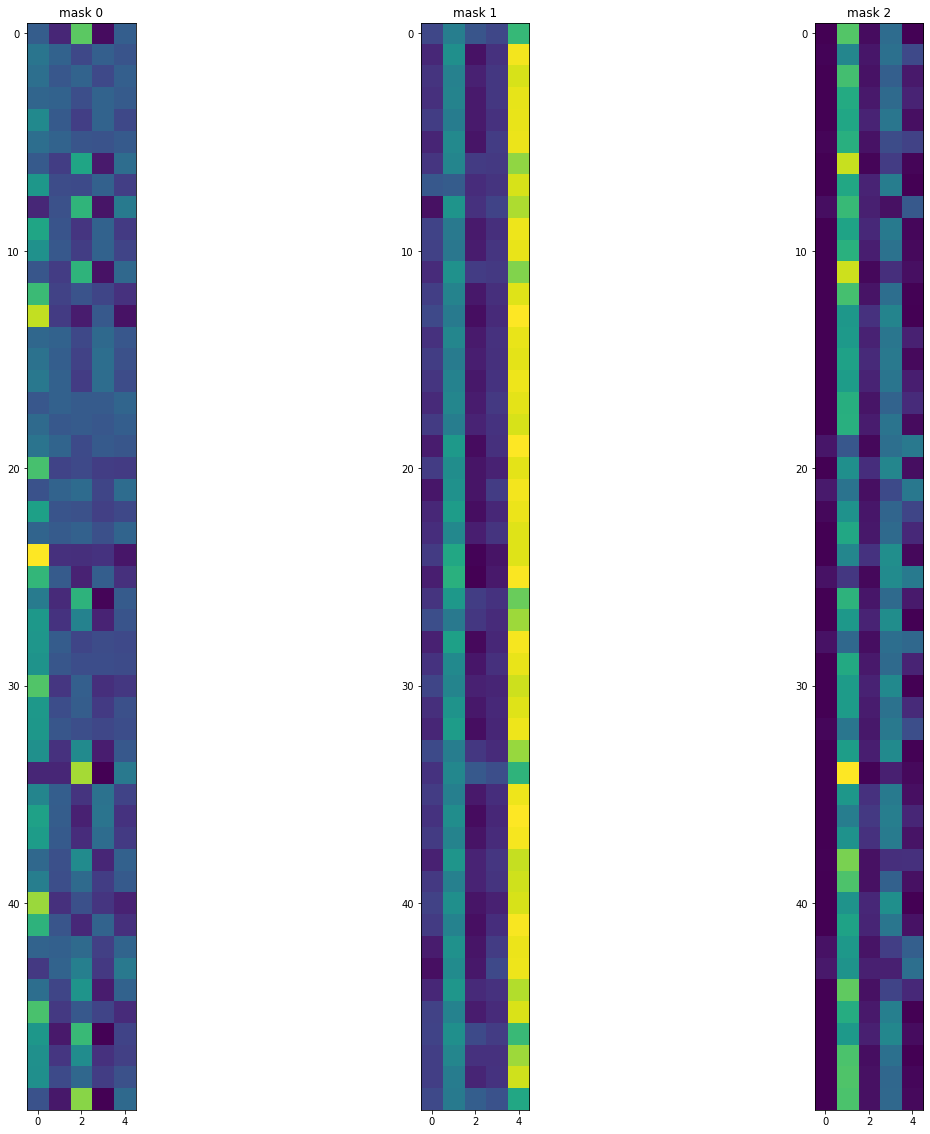

In [6]:
unvised.predict()
loaded_pretrain = unvised.save2load_pretrain_model()

In [7]:
class supervisedTBNet:
    def __init__(self, train_df, target_name, loaded_pretrain, epochs=3):
         
        self.loaded_pretrain = loaded_pretrain
        self.epochs = 1000 if not os.getenv("CI", False) else 2
        self.target_name=target_name
        self.local_interpretability_step = 3
        self.tabnet_params = dict(n_d=15, n_a=15,
                                n_steps=8,
                                gamma=0.2,
                                seed=10,
                                lambda_sparse=1e-3,
                                optimizer_fn=torch.optim.Adam,
                                optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                                mask_type="entmax",
                                scheduler_params=dict(
                                    max_lr=0.05,
                                    steps_per_epoch=int(X_train.shape[0] / 100),
                                    epochs=self.epochs,
                                    is_batch_level=True,
                                ),
                                verbose=5,
                            )
        self.src_df = train_df
        
    def train(self, X_train, X_test, y_train, y_test):
        # model
        self.model = TabNetRegressor(**self.tabnet_params)
        print('total epoch', self.epochs)
        self.model.fit(
            X_train=X_train, y_train=y_train,
            eval_set=[(X_test, y_test)],
            eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
            max_epochs=self.epochs,
            patience=30,
            batch_size=256,
            virtual_batch_size=128,
            num_workers=2,
            drop_last=False,
            loss_fn=torch.nn.functional.l1_loss,
            from_unsupervised=self.loaded_pretrain)
        
        
        print('show feature importance')
        self.plot_metric()
        self.feature_importances()
        self.local_interpretability(X_test) 
        print('prediction')
        pred = self.model.predict(X_test)
        scores = self.calculate_scores(pred, y_test)
        print(scores)
        return self.model, pred, y_test
        
    def plot_metric(self):
        for param in ['loss', 'lr', 'val_0_rmsle', 'val_0_mae', 'val_0_rmse', 'val_0_mse']:
            plt.plot(self.model.history[param], label=param)
            plt.xlabel('epoch')
            plt.grid()
            plt.legend()
            plt.show()
            
    def feature_importances(self):
        df = self.src_df
        feature_name =[str(col) for col in df.columns if col!=self.target_name]
        print(len(feature_name))
        feat_imp = pd.DataFrame(self.model.feature_importances_, index=feature_name)
        feature_importance = feat_imp.copy()

        feature_importance["imp_mean"] = feature_importance.mean(axis=1)
        feature_importance = feature_importance.sort_values("imp_mean")

        plt.tick_params(labelsize=18)
        plt.barh(feature_importance.index.values, feature_importance["imp_mean"])
        plt.title("feature_importance", fontsize=18)
        
    def local_interpretability(self, X_test):
        """どの特徴量を使うか decision making するのに用いた mask(Local interpretability)"""
        n_steps = self.local_interpretability_step
        explain_matrix, masks = self.model.explain(X_test)
        fig, axs = plt.subplots(n_steps, 1, figsize=(21, 3*n_steps))
        
        for i in range(n_steps):
            axs[i].imshow(masks[i][:50].T)
            axs[i].set_title(f"mask {i}")
            axs[i].set_yticks(range(len(self.src_df.columns[:-1])))
            axs[i].set_yticklabels(list(self.src_df.columns[:-1]))
            
    def calculate_scores(self, true, pred):
        scores = {}
        scores = pd.DataFrame(
            {
                "R2": r2_score(true, pred),
                "MAE": mean_absolute_error(true, pred),
                "MSE": mean_squared_error(true, pred),
                "RMSE": np.sqrt(mean_squared_error(true, pred)),
            },
            index=["scores"],
        )
        return scores

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning: Pretraining: n_a changed from 15 to 8
  warnings.warn(wrn_msg)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning: Pretraining: n_d changed from 15 to 8
  warnings.warn(wrn_msg)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning: Pretraining: n_steps changed from 8 to 3
  warnings.warn(wrn_msg)
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:225: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.08506 | val_0_rmsle: 0.01214 | val_0_mae: 0.02988 | val_0_rmse: 0.1608  | val_0_mse: 0.02586 |  0:00:27s
epoch 5  | loss: 0.02581 | val_0_rmsle: 0.01217 | val_0_mae: 0.02533 | val_0_rmse: 0.15912 | val_0_mse: 0.02532 |  0:02:44s
epoch 10 | loss: 0.02511 | val_0_rmsle: 0.01217 | val_0_mae: 0.02532 | val_0_rmse: 0.15913 | val_0_mse: 0.02532 |  0:05:02s
epoch 15 | loss: 0.02497 | val_0_rmsle: 0.01217 | val_0_mae: 0.02532 | val_0_rmse: 0.15913 | val_0_mse: 0.02532 |  0:07:20s
epoch 20 | loss: 0.02493 | val_0_rmsle: 0.01217 | val_0_mae: 0.02532 | val_0_rmse: 0.15913 | val_0_mse: 0.02532 |  0:09:38s
epoch 25 | loss: 0.02494 | val_0_rmsle: 0.01217 | val_0_mae: 0.02532 | val_0_rmse: 0.15913 | val_0_mse: 0.02532 |  0:11:56s
epoch 30 | loss: 0.02493 | val_0_rmsle: 0.01217 | val_0_mae: 0.02532 | val_0_rmse: 0.15913 | val_0_mse: 0.02532 |  0:14:14s

Early stopping occurred at epoch 31 with best_epoch = 1 and best_val_0_mse = 0.02513


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


show feature importance


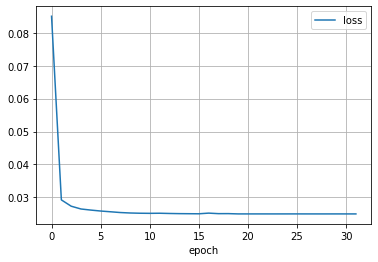

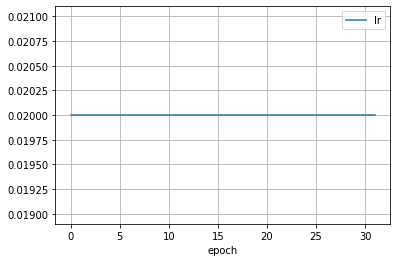

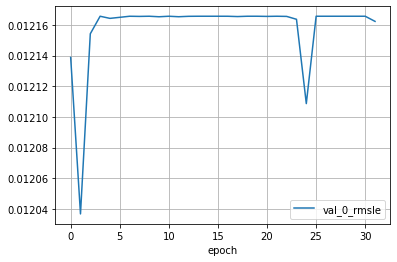

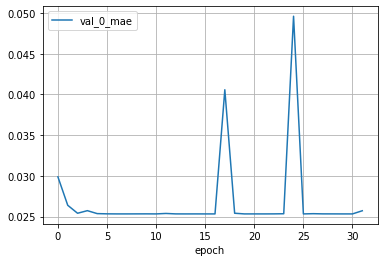

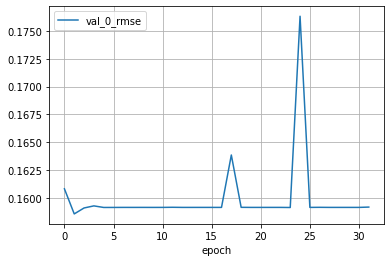

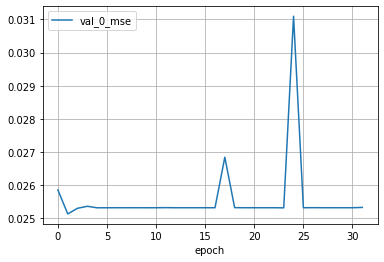

5
prediction
                 R2       MAE       MSE     RMSE
scores -8658.031026  0.026383  0.025135  0.15854


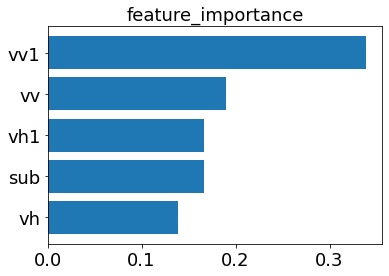

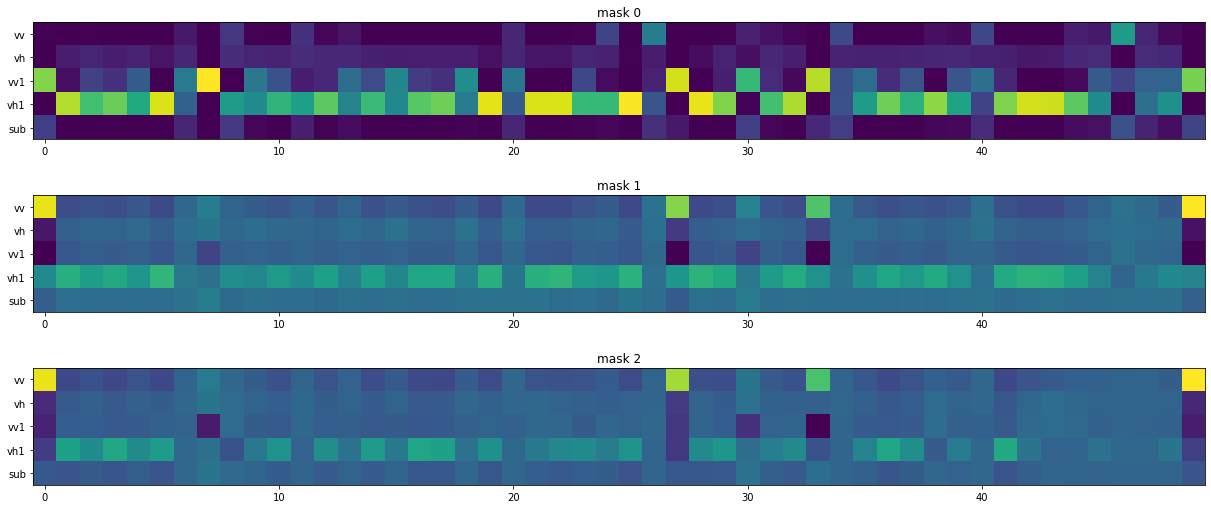

In [8]:
tbnet = supervisedTBNet(df, target_name='test', loaded_pretrain=loaded_pretrain, epochs=100)
model, pred, y_test = tbnet.train(X_trains, X_tests, y_train, y_test)

In [11]:
def heatmaps(test, pred):
    plt.figure()
    print('test')
    plt.imshow(test,interpolation='nearest',vmin=0,vmax=1,cmap='jet')
    plt.colorbar()
    plt.show()
    print('pred')
    plt.imshow(pred,interpolation='nearest',vmin=0,vmax=1,cmap='jet')
    plt.colorbar()
    plt.show()
    
print(y_test.max(), y_test.min(), pred.max(), pred.min(), y_test.shape)
d = {'pred': np.ravel(pred), 'test':np.ravel(y_test)}
pd.DataFrame(data=d).plot()#.get_figure().savefig('df1.png')



1.0 0.0 0.0210687 -0.0034249788 (20536, 1)


ValueError: cannot reshape array of size 20536 into shape (256,256)